In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime 

In [216]:
stocks = ['AAPL', 'FB', 'NFLX', 'AMZN', 'GOOG']
indices = ['DJI', 'GSPC']
diffCols = ['Close', 'Volume']

# Adds a column to df for the day by day change of col
def add_day_change(df, col):
    try:
        df[col + '_Diff'] = pd.to_numeric(df[col]).diff()
    except:
        print("Unable to calculate diff for this column")

# Market dfs will store all of our dataframes for stock market data
market_dfs = {}
for symbol in stocks + indices:
    market_dfs[symbol] = pd.read_csv(symbol + '.csv')
    for diffCol in diffCols:
        add_day_change(market_dfs[symbol], diffCol)

In [217]:
# Plots a trend for a symbol in the dfs dictionary for the col specified. Standardized divides all data by the mean
def plot_trend(symbols, dfs, col, standardize=False):
    # Figsize
    plt.figure(figsize=(10,6))
    
    # Plot each stock's price
    for symbol in symbols: 
        trend = dfs[symbol][col] / np.mean(dfs[symbol][col]) if standardize else dfs[symbol][col]
        plt.plot(trend)
        date = dfs[symbol].Date
        
    # Plot config
    locs, _ = plt.xticks()
    plt.xticks(locs[1:-1], date[0:-1:len(date)//(len(locs)-3)])
    plt.gca().legend(symbols)
    plt.title(f"Standardized {col} over Time" if standardize else f"{col} over Time")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.show()

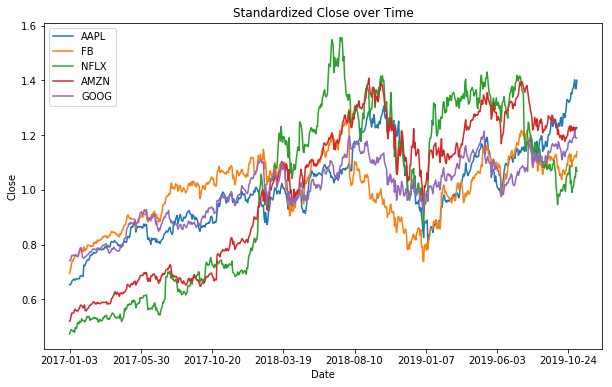

In [218]:
plot_trend(stocks, market_dfs, "Close", standardize=True)

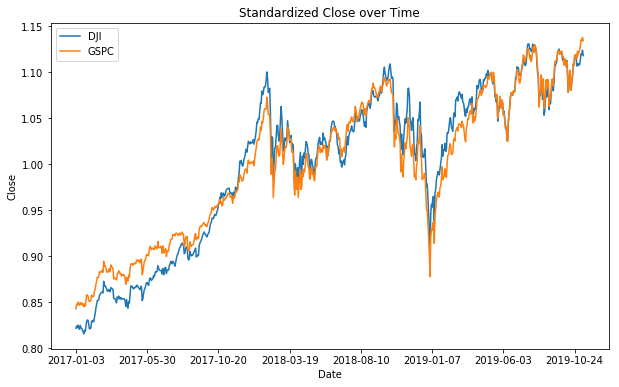

In [219]:
plot_trend(indices, market_dfs, "Close", standardize=True)

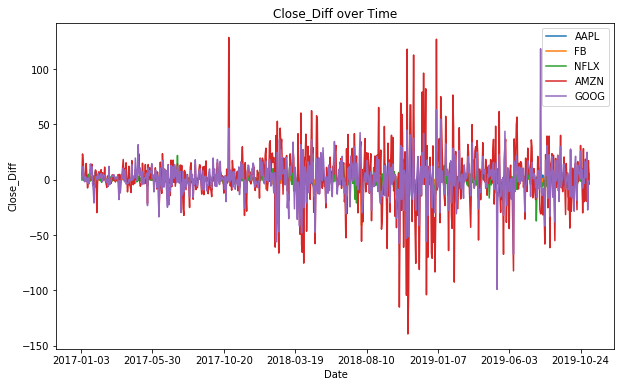

In [220]:
plot_trend(stocks, market_dfs, "Close_Diff")

In [221]:
df_2019 = pd.read_csv('nytimes_2019.csv')
df_2017_18 = pd.read_csv('nytimes_2017_2018.csv')

news_df = pd.concat([df_2017_18, df_2019], ignore_index=True)
news_df.columns

Index(['Unnamed: 0', 'web_url', 'snippet', 'lead_paragraph', 'abstract',
       'print_page', 'source', 'headline', 'headline_kicker',
       'headline_content_kicker', 'headline_print_headline', 'headline_name',
       'headline_seo', 'headline_sub', 'keywords', 'pub_date', 'document_type',
       'news_desk', 'section_name', 'byline', 'type_of_material',
       'word_count'],
      dtype='object')

In [222]:
# percentage of each column that's missing
missing_percents = news_df.isna().sum() / len(news_df)
print(missing_percents)

cols_to_drop = ['Unnamed: 0', 'web_url', 'byline', 'news_desk']
for col in news_df.columns:
    if missing_percents[col] > 0.2:
        cols_to_drop.append(col)

Unnamed: 0                 0.000000
web_url                    0.000063
snippet                    0.000567
lead_paragraph             0.000851
abstract                   0.000473
print_page                 0.341855
source                     0.000000
headline                   0.000000
headline_kicker            0.866316
headline_content_kicker    1.000000
headline_print_headline    0.240260
headline_name              1.000000
headline_seo               1.000000
headline_sub               1.000000
keywords                   0.000000
pub_date                   0.000000
document_type              0.000000
news_desk                  0.053965
section_name               0.000000
byline                     0.000000
type_of_material           0.016234
word_count                 0.000000
dtype: float64


In [223]:
print(cols_to_drop)
news_df = news_df.drop(cols_to_drop,axis=1)

['Unnamed: 0', 'web_url', 'byline', 'news_desk', 'print_page', 'headline_kicker', 'headline_content_kicker', 'headline_print_headline', 'headline_name', 'headline_seo', 'headline_sub']


In [224]:
# Adds sentiment by TextBlob (polarity and subjectivity) to a df based on its col column
def add_sentiment(df, col):
    def polarity_and_subjectivity(x):
        sentiment = TextBlob(str(x)).sentiment
        return sentiment.polarity, sentiment.subjectivity
    df['polarity'], df['subjectivity'] = zip(*df[col].map(polarity_and_subjectivity))

add_sentiment(news_df, 'abstract')

In [225]:
news_df['date'] = news_df['pub_date'].apply(lambda x: x.strip()[:10])

In [226]:
news_by_date = {"date": news_df.date.unique(),"subjectivity": [], "polarity": []}
for date in news_df.date.unique():
    news_by_date["subjectivity"].append(np.mean(news_df.loc[news_df['date'] == date]['subjectivity']))
    news_by_date["polarity"].append(np.mean(news_df.loc[news_df['date'] == date]['polarity']))
avg_sentiment_df = pd.DataFrame(news_by_date).sort_values(by="date")

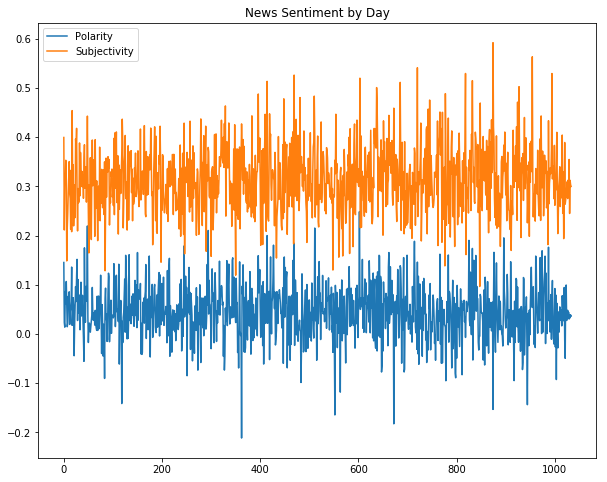

In [227]:
fig = plt.figure(figsize=(10,8))

plt.plot(list(range(len(avg_sentiment_df))), avg_sentiment_df['polarity'])
plt.plot(list(range(len(avg_sentiment_df))), avg_sentiment_df['subjectivity'])
plt.title('News Sentiment by Day')
plt.legend(['Polarity', 'Subjectivity'])

plt.show()